In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV,Lasso, LassoLarsCV, LinearRegression,RANSACRegressor
from sklearn.model_selection import cross_val_score,KFold,train_test_split,cross_val_predict, StratifiedKFold
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as sm
from scipy.stats import norm
import datetime 
from  datetime  import datetime as dt 
from scipy import stats
import operator
from sklearn import cross_validation, grid_search, linear_model, metrics

from sklearn.feature_selection import VarianceThreshold
import re
# import warnings 
# warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [11]:
data = pd.read_csv('dataset1707.csv', sep=';') #
# data = data.loc[data.IS_FIRST==0]
agg686 = pd.read_csv('./doone/fin686.csv', sep=';') #
agg685 = pd.read_csv('./doone/fin685.csv', sep=';') 
agg641 = pd.read_csv('./doone/fin641.csv', sep=';') #
agg560 = pd.read_csv('./doone/fin560.csv', sep=';') #

agg68 = pd.concat([agg686, agg685], ignore_index=1)

data = data.loc[(data['TMP_STP_ALL_AVG']>360)&(data['TMP_STP_ALL_AVG']<700)&(data.TEMP_START_PHASE1!=0)&((data.ADAPTATION_KEY==190409109015)|(data.ADAPTATION_KEY==190309109015))]

data.drop(['TMP_STRT_HED_AVG_M','TMP_STRT_TAIL_AVG_M', 'PROFILE_SDV', u'PROFILE_MIN', u'PROFILE_AVG', u'PROFILE_MAX'], axis=1, inplace=True)
data = data.dropna()

In [3]:
data['Vol'] = data['PLT_TCK']*data['PLT_WID']*data['PLT_LEN']*1e-09
data['MEAS_TIME'] = data['MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%Y %H:%M:%S"))
data['PREV_MEAS_TIME'] = data['PREV_MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%Y %H:%M:%S"))

data['ts_diff'] = (data['TS'] - data['TMP_STP_ALL_AVG']).shift().fillna((data['TS'] - data['TMP_STP_ALL_AVG']).median())  

data['hour'] = 0
data['hour'] = data['MEAS_TIME'].apply(lambda x: x.hour)
data['month']=0
data['month'] = data['MEAS_TIME'].apply(lambda x: x.month)

data['fail'] = 0
data.ix[data.NOT_IN_25_0C==1, 'fail'] = 1
data['meas_date'] =  data['MEAS_TIME'].apply(lambda x: x.date())
data['prev_meas_date'] = data['PREV_MEAS_TIME'].apply(lambda x: x.date())

gg_time = pd.merge(data[[ 'meas_date', 'MEAS_TIME']], data[[ 'meas_date', 'MEAS_TIME','fail']], on='meas_date', how='left')
gg_time['idt'] = 0
gg_time['idt'] = gg_time.MEAS_TIME_x.apply(lambda x: str(x))

# gg_fail =  gg_time.loc[(gg_time.MEAS_TIME_x>gg_time.MEAS_TIME_y)&(gg_time.fail==1)].groupby('idt')['MEAS_TIME_y'].max().reset_index()
# gg_fail.columns = ['MEAS_TIME', 'MEAS_LAST_FAIL']
# gg_fail['MEAS_TIME'] = gg_fail['MEAS_TIME'].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S"))
# data = pd.merge(data, gg_fail, on='MEAS_TIME', how='left')
# data['mins_since_fail'] = (data.MEAS_TIME - data.MEAS_LAST_FAIL).apply(lambda x: x.total_seconds()/60)
# data['mins_since_fail'].fillna(data.mins_since_fail.mean(), inplace=True)


data['diff_mins'] = data['MEAS_TIME'] - data['PREV_MEAS_TIME']
data['diff_mins'] = data['diff_mins'].apply(lambda x: round(x.total_seconds()/60,2))
data['weekday'] = data['MEAS_TIME'].apply(lambda x: x.weekday())
# data['first_cool'] = (data['MEAS_TIME'].apply(lambda x: x.date()) - data['PREV_MEAS_TIME'].apply(lambda x: x.date())).apply(lambda x: x.days)
# data.ix[data.first_cool>0, 'first_cool'] = 1

data['prev_fail'] = data['fail'].shift().fillna(0) 
data['CR_PREV'] = (data['CR_ACT'] - data['CR']).shift().fillna((data['CR_ACT'] - data['CR']).median())  
data['TMP_STP_ALL_PREV'] = data['TMP_STP_ALL_AVG'].shift().fillna(data.TMP_STP_ALL_AVG.median())  
# data['tail_head_diff'] = data['TMP_STRT_HEAD_AVG']- data['TMP_STRT_TAIL_AVG']

data['daypart'] = 0
data.ix[(data.hour>8)&(data.hour<=12), 'daypart'] = 1
data.ix[(data.hour>12)&(data.hour<=16), 'daypart'] = 2
data.ix[(data.hour>16)&(data.hour<=20), 'daypart'] = 3
data.ix[(data.hour>20)&(data.hour<=23), 'daypart'] = 4



not25day = data.groupby('meas_date')['NOT_IN_25_0C'].sum().reset_index()
not40day = data.groupby('meas_date')['NOT_IN_40_0C'].sum().reset_index()

not25day.columns = ['meas_date', 'not25day']

not40day.columns = ['meas_date', 'not40day']

data = pd.merge(pd.merge(data,not25day , on='meas_date'), not40day, on='meas_date')


for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>4, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>36, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ 'EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>9, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: [float(i) for i in x])
    

# for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
#        u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
#     data[col+'_sum'] = data[col].apply(lambda x: sum(x))
    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: np.mean(x))
    
    
    
for col in ['SIDE_SPRAY', 'AIR_BLOWER'] :
    data[col] = data[col].apply(lambda x: str(x.count('0')))
    


agg68.rename(columns={'pltid':'PIECE_ID'}, inplace=1)

df = pd.merge(agg68, data, on='PIECE_ID')    


df.ix[df.month==1,'month']=13
df.ix[df.month==2,'month']=14

# df['40up'] = 0
# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>480), '40up']=1
# df['40down'] = 0
# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<480), '40down']=1
# df['25up'] = 0
# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480), '25up']=1
# df['25down'] = 0
# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<480), '25down']=1

df['outcome'] = 0
df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>510), 'outcome']=1

df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<450), 'outcome']=2

df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480), 'outcome']=3

df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<480),'outcome']=4

todrop = ['GFC.GlobVar.GfcLocRtData.GfcSccWatPrsScc_median', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_mean',
          'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_median', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_std',
          'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenBot_SetV_std', 'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenTop_SetV_std', 
          'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwBot_SetV_std', 'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwTop_SetV_std','dist_from plt_mean_std',
          'dist_from plt_sum_std', 'L_ACC','CR','WBF_NO','PODKAT','PODKAT2','PLT_TCK','PLT_WID','PLT_LEN',
          'NOT_ANALYSIS', 'fail']
    
df.drop(todrop, axis=1, inplace=1)
df.fillna(0, axis=1, inplace=1)

df['BHC_out_flow_sum_diff']=df[ 'BHC_out_act_sum_mean']-df['BHC_flow__out_sum_task_mean']
df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff'] =  df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_mean']-df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_task_mean']
df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff'] =df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_mean'] - df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_task_mean']
df['THC_cen_flow_sum_diff'] = df['THC_cen_flow_sum_act_mean'] - df[ 'THC_flow_cen_sum_task_mean']
df['THC_out_degree_sum_diff'] = df['THC_out_degree_sum_act_mean'] - df['THC_out_degree_sum_task_mean']
df['THC_out_flow_sum_diff'] = df['THC_out_flow_sum_act_mean'] - df[ 'THC_out_flow_sum_task_mean']
    
fail40up = df.loc[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>500)]
fail40down = df.loc[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<500)]
fail25up = df.loc[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480)&(df.NOT_IN_40_0C==0)]
fail25down = df.loc[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<460)&(df.NOT_IN_40_0C==0)]

good = df.loc[(df.TMP_STP_ALL_AVG<482.5)&(df.TMP_STP_ALL_AVG>477.5)]


ad3 = df.loc[df.ADAPTATION_KEY==190309109015]
ad4 = df.loc[df.ADAPTATION_KEY==190409109015]

suspup = df.loc[(df.TMP_STP_ALL_AVG>500)&(df.NOT_IN_40_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
suspdown = df.loc[(df.TMP_STP_ALL_AVG<480)&(df.NOT_IN_40_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
    


numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object' and c!='ADAPTATION_KEY' and c not in ['PPS_PIECE_ID', 'PIECE_ID', 'PIECE_ID_1', 'PIECE_ID_2']]

# df['outcome'] = 0
# df.ix[df.PIECE_ID.isin(fail40up.PIECE_ID), 'outcome'] = 1
# df.ix[df.PIECE_ID.isin(fail25up.PIECE_ID), 'outcome'] = 2
# df.ix[df.PIECE_ID.isin(fail40down.PIECE_ID), 'outcome'] = 3
# df.ix[df.PIECE_ID.isin(fail25down.PIECE_ID), 'outcome'] = 4
# df.ix[df.PIECE_ID.isin(good.PIECE_ID), 'outcome'] = 5

cols = df.columns.difference(['PPS_PIECE_ID','PIECE_ID','PREV_PIECE_ID ','PIECE_ID_2','PIECE_ID_1', 'MEAS_TIME', 'PREV_MEAS_TIME'])


In [7]:
# v = pd.concat([first_g_data, first_baddown_data], axis=0)
# v['resp'] = 'down40'
# v.ix[v.PIECE_ID.isin(first_g_data.PIECE_ID), 'resp'] = 'good'

NameError: name 'first_g_data' is not defined

In [12]:
df.BHC_cen_act_degree_sum_median.value_counts()

0.000      2830
492.822       2
521.220       1
525.390       1
489.541       1
513.533       1
505.694       1
489.627       1
649.272       1
523.964       1
500.017       1
476.241       1
509.239       1
544.286       1
509.776       1
481.647       1
500.281       1
529.336       1
478.019       1
514.892       1
532.885       1
557.663       1
482.278       1
0.044         1
521.217       1
540.122       1
506.894       1
546.358       1
541.088       1
612.708       1
481.291       1
508.592       1
588.089       1
481.878       1
503.166       1
483.374       1
512.609       1
515.292       1
505.073       1
488.323       1
480.781       1
504.947       1
475.012       1
488.132       1
508.908       1
605.805       1
545.509       1
487.030       1
521.956       1
477.871       1
441.316       1
521.191       1
484.125       1
514.294       1
554.862       1
442.678       1
505.491       1
502.066       1
484.195       1
532.818       1
520.764       1
512.601       1
502.411 

In [ ]:
cols = df.columns.difference(['PPS_PIECE_ID','PIECE_ID','PREV_PIECE_ID ','PIECE_ID_2','PIECE_ID_1', 'MEAS_TIME', 'PREV_MEAS_TIME', 'PREV_PIECE_ID', 'NOT_IN_25_0C','NOT_IN_40_0C','IS_FIRST','outcome'])


In [13]:

# first_g_data = df.loc[(df.TMP_STP_ALL_AVG<485)&(data.TMP_STP_ALL_AVG>475)&(data.IS_FIRST==1)]
first_baddown_data = df.loc[(df.TMP_STP_ALL_AVG<480)&((df.IS_FIRST==1)|(df.BATCH_POSITION==1))&(df.NOT_IN_25_0C==1)]

In [9]:
first_badUP_data.BHC_flow__out_sum_task_median

198    0.000
356    0.000
674    0.000
686    0.000
719    0.000
740    0.000
841    0.000
894    0.000
930    0.000
932    0.000
1955   0.000
2303   0.000
2317   0.000
2322   0.000
2323   0.000
2325   0.000
2674   0.000
2677   0.000
2680   0.000
2683   0.000
2685   0.000
2722   0.000
2725   0.000
2737   0.000
2750   0.000
2897   0.000
2905   0.000
3016   0.000
3024   0.000
3189   0.000
3192   0.000
3194   0.000
3198   0.000
3201   0.000
3209   0.000
3294   0.000
3401   0.000
3671   0.000
Name: BHC_flow__out_sum_task_median, dtype: float64

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',264)

j = pd.concat([first_baddown_data[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

j.columns = ['index', 'first25up_mean','good_mean']
j['diff']=0
j['diff'] = abs((j.first25up_mean - j.good_mean)/(j[['first25up_mean','good_mean']].mean(axis=1)))
j.sort_values(by='diff', ascending=0,inplace=1)

j.to_csv('./rel_change/first_down.csv',index=0, sep=';' )
j

,index,first25up_mean,good_mean,diff
114,PLT_ACCELERATION,-0.004,0.013,3.457
50,DEF_CR,1.385,-0.064,2.192
65,DIF_TMP_ALL,-44.580,0.073,2.007
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.000,0.002,2.000
27,BHC_flow__out_sum_task_median,0.000,5170.429,2.000
246,outcome,4.000,0.000,2.000
24,BHC_flow__out_mean_task_median,0.000,254.657,2.000
93,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_std,0.000,0.012,2.000
112,NOT_IN_25_0C,1.000,0.000,2.000
113,NOT_IN_40_0C,0.611,0.000,2.000


In [9]:
data.IS_FIRST.sum()

90L

In [8]:
len(first_badUP_data)

9

In [19]:
8366.859*0.6

5020.1154

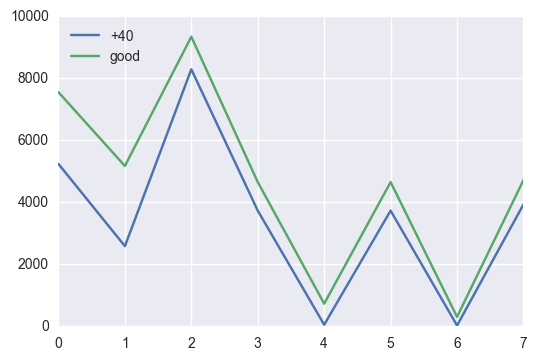

In [66]:
x = np.arange(0,8, 1)
plt.plot(x,d.loc[bb].mean_bad)
plt.plot(x, d.loc[bb].mean_good)
# plt.plot(x, 3 * x)
# plt.plot(x, 4 * x)

plt.legend(['+40', 'good'], loc='upper left')

plt.show()

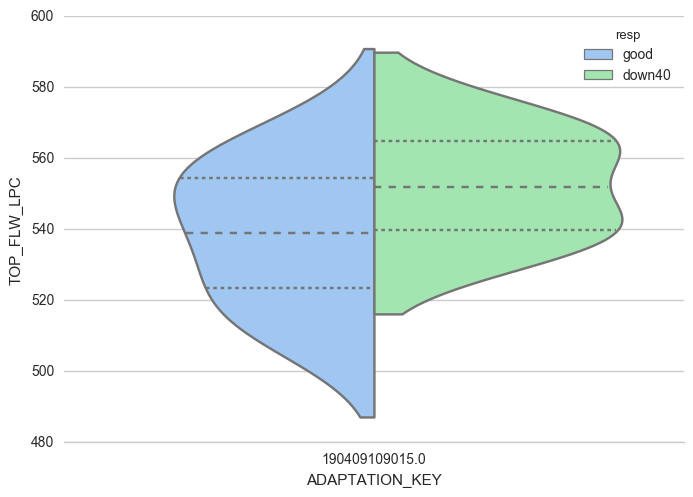

In [89]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

sns.violinplot(x='ADAPTATION_KEY', y="TOP_FLW_LPC", hue="resp", data=v.loc[v.ADAPTATION_KEY==190409109015.000], split=True,
               inner="quart")
sns.despine(left=True)
# pl.figure.savefig('../pres/img/total_pay_vip.png')

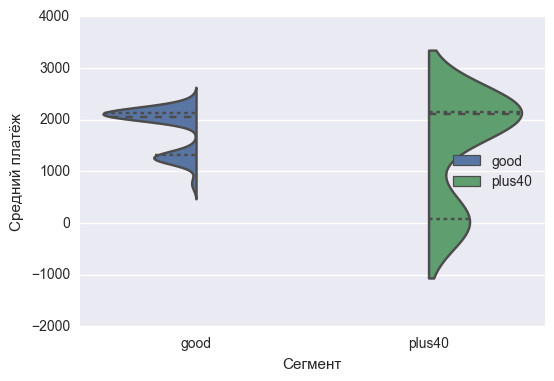

In [71]:
g= sns.violinplot( x = 'resp',y= "SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_task_mean", hue=u"resp", data =v, split=True,
               inner="quart")
sns.despine(left=True)
g.set(xlabel=u'Сегмент', ylabel=u'Средний платёж')
g.legend(loc='right')

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',264)

pd.concat([fail40up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1)

,mean,mean
ADAPTATION_KEY,190326500319.348,190334010975.784
ADAPTION_KEY_CHANGED,0.217,0.253
ADAPT_CR,1.013,1.020
ADAPT_TS_MEAN,0.876,0.905
AVG_MASS_TEMP,1141.087,1142.105
BANKS_HEIGHT,1034.947,1035.408
BATCH_POSITION,1.609,2.361
BATCH_SIZE,3.217,3.701
BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2483.815,2771.201
BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median,1558.440,2259.203


In [99]:
data.loc[data.NOT_IN_40_0C==1].month.value_counts()

11    12
10    12
2     12
8      8
7      5
9      4
12     3
5      1
1      1
Name: month, dtype: int64

In [101]:
data.month.value_counts()

8     1702
11    1677
10    1531
12    1136
9     1003
1      920
2      754
7      535
6       23
5        7
Name: month, dtype: int64

In [100]:
data.loc[data.NOT_IN_25_0C==1].month.value_counts()/data.month.value_counts()

1    0.013
2    0.052
5    0.286
6    0.043
7    0.039
8    0.023
9    0.018
10   0.026
11   0.018
12   0.018
Name: month, dtype: float64

In [4]:
#missing data
# data = data.replace(0, np.nan)

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
not40day,0,0.0
THC_cen_act_sum_mean,0,0.0
THC_flow_cen_mean_task_median,0,0.0
THC_flow_cen_mean_task_mean,0,0.0


In [10]:
first_good = df.loc[(df.TMP_STP_ALL_AVG<485)&(df.TMP_STP_ALL_AVG>475)&(df.IS_FIRST==1)]
first_baddown= df.loc[(df.TMP_STP_ALL_AVG<445)&(df.IS_FIRST==1)]

In [11]:
todrop2 = [ 'L_ACC','CR','WBF_NO','PODKAT','PODKAT2','PLT_TCK','PLT_WID','PLT_LEN','prev_meas_date',
          'NOT_ANALYSIS', 'fail','PPS_PIECE_ID','PIECE_ID','PIECE_ID_2','PIECE_ID_1','PREV_PIECE_ID', 'meas_date', 'MEAS_TIME', 'PREV_MEAS_TIME']
    
data.drop(todrop2, axis=1, inplace=1)

In [77]:
c = ['TMP_STRT_TOT_AVG_M',
 'TMP_STRT_BDY_AVG_M',
 'TMP_STRT_TOT_MAX_M',
 'TMP_STA_TOT_MIN_M',

 'TMP_STRT_HEAD_AVG',
 'TMP_STRT_HEAD_MIN',
 'TMP_STRT_HEAD_MAX',
 'TMP_STRT_HEAD_DEV',
 'TMP_STRT_BDY_AVG',
 'TMP_STRT_BDY_MIN',
 'TMP_STRT_BDY_MAX',
 'TMP_STRT_BDY_DEV',
 'TMP_STRT_TAIL_AVG',
 'TMP_STRT_TAIL_MIN',
 'TMP_STRT_TAIL_MAX',
 'TMP_STRT_TAIL_DEV',
 'TMP_STRT_ALL_AVG',
 'TMP_STRT_ALL_MIN',
 'TMP_STRT_ALL_MAX',
 'TMP_STRT_ALL_DEV',


 'FURT10',
 'FURT40',


 'UNIFORMITY',

 'TEMP_OVERHEATING',
 'TEMP_START_PHASE1',
 'TEMP_START_PHASE2',
 'TEMP_END_PHASE2',
 'DIF_TEMP_START',
 'DIF_TFM',
 'DIF_STRT_TOT_AVG',
 'DIF_STRT_HED_AVG',
 'DIF_STRT_TAIL_AVG',
 'DIF_STRT_TOT',
 'DIF_BDY_HEAD',
 'DIF_BDY_TAIL',

 'Vol']

In [16]:
todd = [ 'TMP_STP_HEAD_AVG',
 'TMP_STP_HEAD_MIN',
 'TMP_STP_HEAD_MAX',
 'TMP_STP_HEAD_DEV',
 'TMP_STP_BDY_AVG',
 'TMP_STP_BDY_MIN',
 'TMP_STP_BDY_MAX',
 'TMP_STP_BDY_DEV',
 'TMP_STP_TAIL_AVG',
 'TMP_STP_TAIL_MIN',
 'TMP_STP_TAIL_MAX',
 'TMP_STP_TAIL_DEV',
 'TMP_STP_ALL_AVG',
 'TMP_STP_ALL_MIN',
 'TMP_STP_ALL_MAX',
 'TMP_STP_ALL_DEV','CR_HEAD',
 'CR_BDY',
 'CR_TAIL',
 'CR_SPRAY_HEAD',
 'CR_SPRAY_BDY',
 'CR_SPRAY_TAIL',
 'CR_LAM_HEAD',
 'CR_LAM_BDY',
 'CR_LAM_TAIL']

first_g_data = data.loc[(data.TMP_STP_ALL_AVG<485)&(data.TMP_STP_ALL_AVG>475)&(data.IS_FIRST==1)].drop(todd, axis=1)
first_baddown_data = data.loc[(data.TMP_STP_ALL_AVG<445)&(data.IS_FIRST==1)].drop(todd, axis=1)

In [ ]:
565 3248
1648 7264
3366 3248
3366 7264
4463 7990
7004 3248
8122 7990

In [17]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.loc[7990],first_g_data.loc[8122] ], axis=1).reset_index()

KeyError: 'the label [7990] is not in the [index]'

In [18]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.loc[3248],first_g_data.loc[7004] ], axis=1).reset_index()

KeyError: 'the label [3248] is not in the [index]'

In [19]:
# очень похожи

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.loc[7990],first_g_data.loc[4463 ] ], axis=1).reset_index()

KeyError: 'the label [7990] is not in the [index]'

In [57]:
# очень похожи

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.loc[7264],first_g_data.loc[3366] ], axis=1).reset_index()

,index,7264,3366
0,RES_TIM_STRT_COMPL,336.654,282.143
1,TMP_STRT_TOT_AVG_M,749.324,750.737
2,TMP_STRT_BDY_AVG_M,750.257,750.826
3,TMP_STRT_TOT_MAX_M,756.219,753.454
4,TMP_STA_TOT_MIN_M,740.971,747.493
5,TMP_STRT_HEAD_AVG,753.486,757.021
6,TMP_STRT_HEAD_MIN,742.964,750.936
7,TMP_STRT_HEAD_MAX,757.723,759.777
8,TMP_STRT_HEAD_DEV,4.601,2.886
9,TMP_STRT_BDY_AVG,755.103,756.634


In [58]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.loc[3248],first_g_data.loc[3366] ], axis=1).reset_index()

,index,3248,3366
0,RES_TIM_STRT_COMPL,332.296,282.143
1,TMP_STRT_TOT_AVG_M,740.467,750.737
2,TMP_STRT_BDY_AVG_M,741.384,750.826
3,TMP_STRT_TOT_MAX_M,746.561,753.454
4,TMP_STA_TOT_MIN_M,733.968,747.493
5,TMP_STRT_HEAD_AVG,748.797,757.021
6,TMP_STRT_HEAD_MIN,738.623,750.936
7,TMP_STRT_HEAD_MAX,753.474,759.777
8,TMP_STRT_HEAD_DEV,4.468,2.886
9,TMP_STRT_BDY_AVG,747.329,756.634


In [59]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.loc[7264],first_g_data.loc[1648] ], axis=1).reset_index()

,index,7264,1648
0,RES_TIM_STRT_COMPL,336.654,272.509
1,TMP_STRT_TOT_AVG_M,749.324,753.999
2,TMP_STRT_BDY_AVG_M,750.257,756.154
3,TMP_STRT_TOT_MAX_M,756.219,759.600
4,TMP_STA_TOT_MIN_M,740.971,742.161
5,TMP_STRT_HEAD_AVG,753.486,760.731
6,TMP_STRT_HEAD_MIN,742.964,748.943
7,TMP_STRT_HEAD_MAX,757.723,766.667
8,TMP_STRT_HEAD_DEV,4.601,5.569
9,TMP_STRT_BDY_AVG,755.103,761.085


In [60]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.loc[3248],first_g_data.loc[565] ], axis=1).reset_index()

,index,3248,565
0,RES_TIM_STRT_COMPL,332.296,271.369
1,TMP_STRT_TOT_AVG_M,740.467,747.702
2,TMP_STRT_BDY_AVG_M,741.384,748.496
3,TMP_STRT_TOT_MAX_M,746.561,752.648
4,TMP_STA_TOT_MIN_M,733.968,742.052
5,TMP_STRT_HEAD_AVG,748.797,753.698
6,TMP_STRT_HEAD_MIN,738.623,745.160
7,TMP_STRT_HEAD_MAX,753.474,756.939
8,TMP_STRT_HEAD_DEV,4.468,3.238
9,TMP_STRT_BDY_AVG,747.329,753.227


In [180]:
d1 = first_g_data[c]
d2 = first_baddown_data[c]
dist = []

for x in first_g_data.index:
    for y in first_baddown_data.index:
        print x, y, np.sum((d1.loc[x] - d2.loc[y])**2)
        

565 1174 7344.83414056
565 3248 1964.32729233
565 5757 23783.6152811
565 6834 9659.2161748
565 7264 2892.07632039
565 7310 8060.75032895
565 7990 14807.7300994
565 8534 22622.7223681
565 8706 14083.2267132
1648 1174 4262.18947493
1648 3248 5970.08918965
1648 5757 18825.311042
1648 6834 7247.70363741
1648 7264 1811.67293128
1648 7310 4831.12629117
1648 7990 9119.21680305
1648 8534 24078.6437828
1648 8706 8276.98362584
3095 1174 6583.38684083
3095 3248 7648.37989333
3095 5757 32022.2635973
3095 6834 17222.3628359
3095 7264 5639.36499564
3095 7310 11180.4515987
3095 7990 18879.8510391
3095 8534 14593.804009
3095 8706 12898.3869442
3120 1174 5191.91442213
3120 3248 7850.1991579
3120 5757 17184.4844001
3120 6834 7866.67737432
3120 7264 2377.00434965
3120 7310 4393.30958039
3120 7990 8129.66972331
3120 8534 19519.3316584
3120 8706 7104.81718044
3148 1174 4142.8052294
3148 3248 5079.3353883
3148 5757 38179.0942481
3148 6834 20693.6507199
3148 7264 4628.63747934
3148 7310 15142.5613874
3148 79

In [43]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',100)

pd.concat([first_baddown_data.describe().loc['mean'],first_g_data.describe().loc['mean'] ], axis=1).reset_index().to_csv('./tables/first_baddown_data_good_mean.csv')

In [105]:
first_bad.month

532     13
742     14
2061     9
3208    11
Name: month, dtype: int64

In [96]:
data.loc[data.NOT_IN_25_0C==1]['daypart'].value_counts().reset_index().sort_values(by='index')['daypart']/data['daypart'].value_counts().reset_index().sort_values(by='index')['daypart']

0    0.022978
1    0.030868
2    0.024104
3    0.024151
4    0.018730
Name: daypart, dtype: float64

In [474]:
data.loc[data.NOT_IN_25_0C==1]['hour'].value_counts()

13    17
10    15
18    14
1     13
4     13
2     12
14    12
22    12
17    10
16    10
20     9
15     9
7      9
11     8
8      8
0      8
9      8
21     8
3      7
6      6
12     6
19     4
5      3
23     3
Name: hour, dtype: int64

In [99]:
data.loc[data.NOT_IN_40_0C==1]['hour'].value_counts()/data['hour'].value_counts()

0     0.007353
1     0.014742
2     0.002451
3          NaN
4     0.018667
5          NaN
6     0.002786
7     0.005714
8          NaN
9     0.010753
10    0.012887
11    0.008108
12    0.004975
13    0.007895
14    0.007463
15    0.012755
16    0.005540
17    0.002404
18    0.002591
19         NaN
20    0.002577
21    0.004963
22    0.009804
23    0.004796
Name: hour, dtype: float64

In [472]:
data.loc[data.NOT_IN_25_0C==1]['hour'].value_counts()

13    17
10    15
18    14
1     13
4     13
2     12
14    12
22    12
17    10
16    10
20     9
15     9
7      9
11     8
8      8
0      8
9      8
21     8
3      7
6      6
12     6
19     4
5      3
23     3
Name: hour, dtype: int64

In [360]:
not40day.loc[not40day.not40day>3]

,meas_date,not40day
5,0016-07-29,5
44,0016-10-18,5
64,0016-11-17,4
109,0017-02-16,7
110,0017-02-17,4


In [327]:
not25day.meas_date[110]

datetime.date(17, 2, 17)

In [326]:
not25day.loc[not25day.not25day>3]

,meas_date,not25day
4,0016-07-28,6
5,0016-07-29,10
7,0016-08-04,5
8,0016-08-05,4
13,0016-08-20,4
19,0016-08-26,4
22,0016-08-29,9
30,0016-09-13,8
38,0016-10-12,5
44,0016-10-18,11


In [33]:
agg56 = pd.concat([agg641, agg560], ignore_index=1)

In [252]:
fail40up.ADAPTATION_KEY.value_counts()

1.903091e+11    28
1.904091e+11     9
Name: ADAPTATION_KEY, dtype: int64

In [253]:
fail25up.ADAPTATION_KEY.value_counts()

1.903091e+11    80
1.904091e+11    56
Name: ADAPTATION_KEY, dtype: int64

In [254]:
fail25down.ADAPTATION_KEY.value_counts()

1.903091e+11    21
1.904091e+11    12
Name: ADAPTATION_KEY, dtype: int64

In [255]:
fail40down.ADAPTATION_KEY.value_counts()

1.903091e+11    14
1.904091e+11     7
Name: ADAPTATION_KEY, dtype: int64

In [256]:
good.ADAPTATION_KEY.value_counts()

1.903091e+11    1187
1.904091e+11     609
Name: ADAPTATION_KEY, dtype: int64

In [257]:
good.shape

(1796, 135)

In [44]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',245)

pd.concat([ad3[cols].describe().loc['mean'],ad4[cols].describe().loc['mean'] ], axis=1).reset_index().to_csv('./tables/ad3ad4.csv')

In [45]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',245)

pd.concat([ad3[cols].describe().loc['max'],ad4[cols].describe().loc['max'] ], axis=1).reset_index().to_csv('./tables/ad3ad4max.csv')

In [397]:
data.shape

(9288, 144)

In [24]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

pd.concat([df.loc[(df.meas_date ==datetime.date(17, 2, 16))&(df.TMP_STP_ALL_AVG>480)&(df.NOT_IN_25_0C==1)][cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

,index,mean,mean
0,ADAPTATION_KEY,190323394729.286,190334010975.784
1,ADAPTION_KEY_CHANGED,0.286,0.253
2,ADAPT_CR,1.048,1.020
3,ADAPT_TS_MEAN,0.850,0.905
4,AVG_MASS_TEMP,1139.000,1142.105
5,BANKS_HEIGHT,1035.099,1035.408
6,BATCH_POSITION,2.714,2.361
7,BATCH_SIZE,4.000,3.701
8,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2878.489,2771.201
9,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median,2506.163,2259.203


In [25]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

pd.concat([df.loc[(df.meas_date ==datetime.date(17, 2, 16))&(df.TMP_STP_ALL_AVG<480)&(df.NOT_IN_25_0C==1)][cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

,index,mean,mean
0,ADAPTATION_KEY,190309109015.000,190334010975.784
1,ADAPTION_KEY_CHANGED,0.000,0.253
2,ADAPT_CR,1.040,1.020
3,ADAPT_TS_MEAN,0.879,0.905
4,AVG_MASS_TEMP,1142.000,1142.105
5,BANKS_HEIGHT,1035.099,1035.408
6,BATCH_POSITION,1.667,2.361
7,BATCH_SIZE,3.333,3.701
8,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2694.349,2771.201
9,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median,1889.984,2259.203


In [428]:
good.TMP_STRT_ALL_AVG.max()

775.55670170000008

In [61]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

pd.concat([suspup[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1)

,mean,mean
ADAPTATION_KEY,190324493630.385,190334010975.784
ADAPTION_KEY_CHANGED,0.308,0.253
ADAPT_CR,1.005,1.020
ADAPT_TS_MEAN,0.880,0.905
AVG_MASS_TEMP,1141.077,1142.105
BANKS_HEIGHT,1034.882,1035.408
BATCH_POSITION,1.308,2.361
BATCH_SIZE,2.769,3.701
BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2436.836,2771.201
BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median,1266.023,2259.203


In [62]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

pd.concat([suspdown[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

,index,mean,mean
0,ADAPTATION_KEY,190346609015.000,190334010975.784
1,ADAPTION_KEY_CHANGED,0.625,0.253
2,ADAPT_CR,0.991,1.020
3,ADAPT_TS_MEAN,0.902,0.905
4,AVG_MASS_TEMP,1143.375,1142.105
5,BANKS_HEIGHT,1035.043,1035.408
6,BATCH_POSITION,1.625,2.361
7,BATCH_SIZE,3.375,3.701
8,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2618.656,2771.201
9,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median,1613.685,2259.203


In [139]:
first_bad['TMP_STRT_HEAD_AVG']

532    765.509
742    754.456
2061   748.797
3208   743.760
Name: TMP_STRT_HEAD_AVG, dtype: float64

In [140]:
first_good['TMP_STRT_HEAD_AVG']

2026   758.624
2065   751.636
2541   762.786
Name: TMP_STRT_HEAD_AVG, dtype: float64

In [63]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',275)

pd.concat([first_bad[cols].describe().loc['mean'],first_good[cols].describe().loc['mean'] ], axis=1).reset_index()

NameError: name 'first_bad' is not defined

In [148]:
df.loc[df['SPEED']>1.6]['NOT_IN_40_0C']

356     1
1955    1
2319    1
4120    1
Name: NOT_IN_40_0C, dtype: int64

In [80]:
df.shape

(5474, 264)

In [89]:
fail40up.month

356     12
841      2
842      2
932      2
1769     2
1858     2
1860     2
1955     9
2319    10
2325    10
2674    10
2677    10
2680    10
2722    11
3029    11
3192    11
3194    11
3198    11
3201    11
3209    11
4019    10
4120    10
4787    11
Name: month, dtype: int64

In [33]:
data.loc[data.NOT_IN_40_0C==1].shape

(66, 135)

In [64]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',131)

pd.concat([fail25up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

,index,mean,mean
0,ADAPTATION_KEY,190341944835.896,190334010975.784
1,ADAPTION_KEY_CHANGED,0.194,0.253
2,ADAPT_CR,1.017,1.020
3,ADAPT_TS_MEAN,0.879,0.905
4,AVG_MASS_TEMP,1141.493,1142.105
5,BANKS_HEIGHT,1036.031,1035.408
6,BATCH_POSITION,2.299,2.361
7,BATCH_SIZE,3.567,3.701
8,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2893.219,2771.201
9,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median,2550.422,2259.203


In [65]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',131)

pd.concat([fail40down[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

,index,mean,mean
0,ADAPTATION_KEY,190329109015.000,190334010975.784
1,ADAPTION_KEY_CHANGED,0.533,0.253
2,ADAPT_CR,0.994,1.020
3,ADAPT_TS_MEAN,0.915,0.905
4,AVG_MASS_TEMP,1144.200,1142.105
5,BANKS_HEIGHT,1034.875,1035.408
6,BATCH_POSITION,1.400,2.361
7,BATCH_SIZE,3.267,3.701
8,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2600.252,2771.201
9,BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median,1457.217,2259.203


In [114]:
df.outcome.value_counts()

0    4328
5    1020
2      67
1      23
4      21
3      15
Name: outcome, dtype: int64

In [116]:
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object' and c!='ADAPTATION_KEY' and c not in ['PPS_PIECE_ID', 'PIECE_ID', 'PIECE_ID_1', 'PIECE_ID_2']]

# Correlation tells relation between two attributes.
# Correlation requires continous data. Hence, ignore categorical data

# Calculates pearson co-efficient for all combinations
size = 72
cols=df[numerical_columns].columns 
data_corr = df.corr()

# Set the threshold to select only highly correlated attributes
threshold = 0.7

# List of pairs along with correlation above threshold
corr_list = []

#Search for the highly correlated pairs
for i in range(0,size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatLpc_ActV_mean and GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatLpc_ActV_median = 1.00
GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiGenWtsAirTmp_ActV_mean and GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiGenWtsAirTmp_ActV_median = 1.00
GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatScc_ActV_mean and GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatScc_ActV_median = 1.00
GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwBot_SetV_mean and GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwBot_SetV_median = 1.00
GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMod_ActV_mean and GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMod_ActV_median = 1.00
GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwTop_SetV_mean and GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwTop_SetV_median = 1.00
GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_mean and GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_median = 1.00
GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_mean and GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_median = 1.00
SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_std and SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_task_std = 1.00
BH

In [502]:
corr = df[numerical_columns].select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()

cor_dict = corr['TMP_STP_ALL_AVG'].to_dict()
del cor_dict['TMP_STP_ALL_AVG']
print("List the numerical features decendingly by their correlation with Sale Price:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))
    

sorted_corr = sorted(cor_dict.items(), key=lambda x: -abs(x[1]))
    
best = []
for x in range(5,40):
    best.append(sorted_corr[x][0])

List the numerical features decendingly by their correlation with Sale Price:

DIF_TMP_ALL: 	1.0
TMP_STP_BDY_AVG: 	0.992728413352
TMP_STP_TAIL_AVG: 	0.946235307704
TMP_STP_HEAD_AVG: 	0.926921734211
TMP_STP_TAIL_MAX: 	0.795393258221
TMP_STP_HEAD_MAX: 	0.743208585263
CR_SPRAY_BDY: 	-0.673532989349
CR_BDY: 	-0.669398978409
CR_LAM_BDY: 	-0.656784789253
CR_SPRAY_HEAD: 	-0.568868070989
CR_LAM_HEAD: 	-0.55300865637
WBF_COL_NO: 	-0.39494860849
BHC_cen_degree_sum_task_median: 	0.363955442739
BHC_out_degree_sum_task_median: 	0.363749789931
BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median: 	0.36357663632
BHC_flow__out_mean_task_median: 	0.36324590809
BHC_out_act_mean_median: 	0.362855340698
THC_cen_flow_sum_act_median: 	0.361763110596
THC_flow_cen_mean_task_median: 	0.360214974498
TEMP_END_PHASE2: 	-0.336507880223
BHC_cen_act_degree_sum_mean: 	0.335551398549
BHC_cen_degree_sum_task_mean: 	0.335041795316
THC_cen_act_sum_median: 	0.333482168836
BHC_cen_flow_sum_act_mean: 	0.331663940424
BHC_out_act_mea

In [13]:
df.WBF_COL_NO.value_counts()

1.0    2740
2.0    2734
Name: WBF_COL_NO, dtype: int64

In [17]:
df.loc[df.NOT_IN_40_0C==1]['WBF_COL_NO'].value_counts()

2.0    26
1.0    12
Name: WBF_COL_NO, dtype: int64

In [35]:
sum(df.loc[df.WBF_COL_NO==2]['TMP_STP_ALL_AVG']-480)/ 2734

-3.4578404238478337

In [33]:
sum(abs(df.loc[df.WBF_COL_NO==1]['TMP_STP_ALL_AVG']-480))

22784.417663100041

In [32]:
sum(abs(df.loc[df.WBF_COL_NO==2]['TMP_STP_ALL_AVG']-480))

22091.481324600034

In [36]:
sum(df.loc[df.WBF_COL_NO==1]['TMP_STP_ALL_AVG']-480)/2740

5.0146061582116808

In [40]:
df.BATCH_POSITION.value_counts()

1.0    1570
2.0    1563
3.0    1209
4.0    1110
5.0      22
Name: BATCH_POSITION, dtype: int64

In [49]:
df.diff_mins.median()

4.67

In [48]:
df.loc[(df.IS_FIRST!=1)&(df.BATCH_POSITION==1)&(df.NOT_IN_40_0C==1)]['diff_mins']

356     40.65
841     22.45
843     38.65
859     24.80
900     26.73
904     26.07
932     26.13
1955    26.62
2187    22.52
2325    23.75
2329    23.57
2674    23.02
2677    23.63
2680    23.48
3192    23.00
3194    23.83
3198    23.75
3201    24.08
3209    22.58
3542    29.23
Name: diff_mins, dtype: float64

In [151]:
fail40up.shape

(23, 254)

In [ ]:
df.loc[df.NOT_IN_40_0C==1]['BATCH_POSITION'].value_counts()

In [ ]:
df.loc[df.WBF_NO==1]['TMP_STP_ALL_AVG']-480

In [10]:
corr = df[numerical_columns].select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()

cor_dict = corr['40up'].to_dict()
# del cor_dict['40up']
print("List the numerical features decendingly by their correlation with Sale Price:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))
    

sorted_corr = sorted(cor_dict.items(), key=lambda x: -abs(x[1]))
    
best = []
for x in range(5,40):
    best.append(sorted_corr[x][0])

KeyError: '40up'

In [32]:
agg_good.fillna(0, inplace=1)
agg40up.fillna(0, inplace=1)

c = agg40up.ix[:, agg40up.columns !='PIECE_ID'].columns

NameError: name 'agg_good' is not defined

In [31]:
b = agg_good.describe().loc['mean'] - agg40up.describe().loc['mean']
b.reset_index().sort_values(by='mean',ascending=0).head(10)

NameError: name 'agg_good' is not defined

In [51]:
df.drop(['TMP_STP_HEAD_DEV',
 'TMP_STP_BDY_DEV',
 'TMP_STP_TAIL_DEV',
 'TMP_STP_ALL_DEV',
           'CR_ACT',
#            'FURT10',
#  'FURT40',
 'DIF_TMP_ALL',
           'DEF_CR',
            'DIF_BDY_HEAD',
 'DIF_BDY_TAIL',
 'DIF_SPRAY_BDY_HEAD',
 'DIF_SPRAY_BDY_TAIL',
 'DIF_LAM_BDY_HEAD',
 'DIF_LAM_BDY_TAIL',
 'DIF_BDY_HEAD_AVG',
 'DIF_BDY_TAIL_AVG',
           'TS'
          ], inplace =True, axis = 1)




In [56]:
len(df)

5474

In [62]:
df.loc[df.NOT_IN_40_0C==1]['HEADERS'].value_counts()

22    17
24    10
23     8
25     3
Name: HEADERS, dtype: int64

In [61]:
df.loc[['HEADERS'].value_counts()

22    2972
23    1608
24     772
25     109
21       7
20       5
18       1
Name: HEADERS, dtype: int64

In [63]:
df.columns.tolist()

['BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean',
 'BHC._BhcRtData.BhcRtData.WatAbsFlwSum_median',
 'BHC._BhcRtData.BhcRtData.WatAbsFlwSum_std',
 'BHC_cen_act_degree_sum_mean',
 'BHC_cen_act_degree_sum_median',
 'BHC_cen_act_degree_sum_std',
 'BHC_cen_degree_sum_task_mean',
 'BHC_cen_degree_sum_task_median',
 'BHC_cen_degree_sum_task_std',
 'BHC_cen_flow_act_mean_mean',
 'BHC_cen_flow_act_mean_median',
 'BHC_cen_flow_act_mean_std',
 'BHC_cen_flow_sum_act_mean',
 'BHC_cen_flow_sum_act_median',
 'BHC_cen_flow_sum_act_std',
 'BHC_flow__out_mean_task_mean',
 'BHC_flow__out_mean_task_median',
 'BHC_flow__out_mean_task_std',
 'BHC_flow__out_sum_task_mean',
 'BHC_flow__out_sum_task_median',
 'BHC_flow__out_sum_task_std',
 'BHC_out_act_mean_mean',
 'BHC_out_act_mean_median',
 'BHC_out_act_mean_std',
 'BHC_out_act_sum_mean',
 'BHC_out_act_sum_median',
 'BHC_out_act_sum_std',
 'BHC_out_degree_sum_task_mean',
 'BHC_out_degree_sum_task_median',
 'BHC_out_degree_sum_task_std',
 'GFC.Ai._aiGfcAirPrs_me

In [219]:
for col in df.columns:
        print 'Column: ', col,'\n', df[col].value_counts(),'\n',col,' fail ', '\n'

Column:  BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean 
3352.260    1
2089.943    1
2314.553    1
2370.597    1
3118.114    1
2364.121    1
2356.836    1
2292.656    1
3452.966    1
3299.791    1
3493.960    1
2384.813    1
2244.957    1
2176.495    1
3306.052    1
3279.382    1
3401.409    1
3331.188    1
2272.368    1
2976.686    1
3029.466    1
3442.879    1
3201.341    1
2220.059    1
2988.692    1
2277.345    1
2628.894    1
2299.565    1
3181.998    1
2261.501    1
2364.514    1
3168.396    1
3418.770    1
3197.126    1
3212.818    1
2253.988    1
2509.028    1
2352.849    1
3288.566    1
2421.378    1
3139.881    1
3301.704    1
3413.815    1
2240.908    1
2359.209    1
3159.749    1
3115.117    1
3327.608    1
3311.614    1
2430.914    1
           ..
2039.910    1
3465.177    1
3050.816    1
2389.371    1
3740.208    1
2128.742    1
2303.518    1
3155.463    1
2722.517    1
2153.545    1
2367.547    1
3451.288    1
3324.818    1
2456.296    1
2377.390    1
3331.768    1
2282.923 

In [238]:
num_to_categ = []
for col in [c for c in df.columns if df[c].dtype.name != 'object' and c!='TMP_STP_ALL_AVG']:
    if len(df[col].unique())<20:
        num_to_categ.append(col)
        print col, ' : ', len(df[col].unique()), '\n'

GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenBot_SetV_median  :  19 

GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenTop_SetV_median  :  18 

HEAD_MASKING_TOP_LENGTH  :  18 

HEAD_MASKING_BOTTOM_LENGTH  :  19 

TAIL_MASKING_TOP_LENGTH  :  10 

TAIL_MASKING_BOTTOM_LENGTH  :  11 

IS_FIRST  :  2 

ADAPTION_KEY_CHANGED  :  2 

prev_fail  :  2 

